In [59]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import pandas as pd
import io
import glob
import requests
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import pandas as pd
os.chdir(r"C:\Users\14159\Desktop\AI")

In [60]:
%matplotlib inline
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [61]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [62]:
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "UNSW_NB15_training-set_csc215.csv", index=False, encoding='utf-8-sig')

In [63]:
data=combined_csv
data


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [64]:
data.drop(['id'], axis=1, inplace=True)

In [65]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
 

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [66]:
data11=data

In [40]:
#

In [41]:
state = encode_text_dummy(data,"state")
service = encode_text_dummy(data,"service")
proto = encode_text_dummy(data,"proto")
attack_cat = encode_text_dummy(data,"attack_cat")

In [42]:
#x,y=to_xy(data,'label')
data1=data

In [43]:
encode_numeric_zscore(data,['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'])



In [44]:
data.drop(['service--'], axis=1, inplace=True)

In [45]:
data1=data

In [129]:
import io
import requests
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil



def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)



In [130]:
x,y=to_xy(data1,'label')

In [131]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [132]:
from tensorflow.keras.callbacks import EarlyStopping
import io
import requests
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42

model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(y.shape[1],activation='softmax'))


In [133]:
model.compile(loss='categorical_crossentropy', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

model.load_weights('best_weights.hdf5')

Train on 193254 samples, validate on 64419 samples
Epoch 1/1000
193254/193254 - 13s - loss: 0.0562 - val_loss: 0.0029
Epoch 2/1000
193254/193254 - 15s - loss: 0.0025 - val_loss: 9.8730e-04
Epoch 3/1000
193254/193254 - 16s - loss: 0.0012 - val_loss: 5.1282e-04
Epoch 4/1000
193254/193254 - 16s - loss: 7.4709e-04 - val_loss: 4.3827e-04
Epoch 00004: early stopping


In [134]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1) # raw probabilities to choose class (highest probability)
print(y_pred)
y_test = np.argmax(y_test, axis = 1)
print(y_test)

[0 1 1 ... 1 1 1]
[0 1 1 ... 1 1 1]


In [135]:
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.9999534298886974

In [136]:
score = metrics.precision_score(y_test, y_pred, average= "weighted")
print("Precision-score: {}".format(score))

Precision-score: 0.999953435898778


In [137]:
score = metrics.recall_score(y_test, y_pred, average= "weighted")
print("Recall-score: {}".format(score))

Recall-score: 0.9999534298886974


In [138]:
score = metrics.f1_score(y_test,  y_pred, average= "weighted")
print("F1-score: {}".format(score))

F1-score: 0.9999534305430328


In [139]:
classification = metrics.classification_report(y_test, y_pred)

In [140]:
print(confusion_matrix)
print(classification)
print(accuracy)

<function confusion_matrix at 0x000002268DF1E5E8>
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23243
           1       1.00      1.00      1.00     41176

    accuracy                           1.00     64419
   macro avg       1.00      1.00      1.00     64419
weighted avg       1.00      1.00      1.00     64419

0.9999534298886974


[[23243     0]
 [    3 41173]]
Plotting confusion matrix


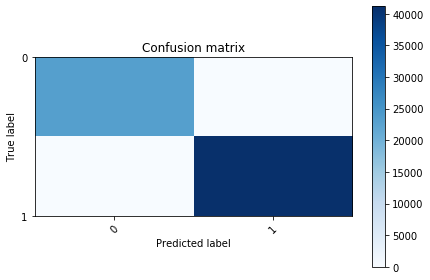

In [141]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, [0, 1])
plt.show()

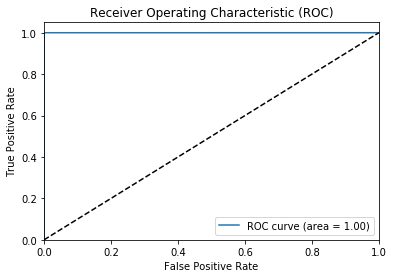

In [142]:
plot_roc(y_pred,y_test)

In [67]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)



attack_cat = encode_text_index(data11,"attack_cat")
state = encode_text_dummy(data11,"state")
service = encode_text_dummy(data11,"service")
proto = encode_text_dummy(data11,"proto")



In [68]:
encode_numeric_zscore(data11,['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'])


In [69]:
x,y = to_xy(data11,'attack_cat')

# Split into train/test


In [70]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [71]:
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(Dense(25, input_dim=x_train.shape[1], activation='relu'))
#model.add(Dense(10))
model.add(Dense(15,activation='relu',input_dim=20))
#model.add(Dropout(0.5))
model.add(Dense(10))
#model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights1.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=1000,batch_size=128)

#score = model.evaluate(x_test, y_test, batch_size=128)

model.load_weights('best_weights1.hdf5') # load weights from best model

Train on 193254 samples, validate on 64419 samples
Epoch 1/1000
193254/193254 - 6s - loss: 0.5715 - val_loss: 0.4254
Epoch 2/1000
193254/193254 - 5s - loss: 0.4104 - val_loss: 0.4029
Epoch 3/1000
193254/193254 - 5s - loss: 0.3947 - val_loss: 0.3951
Epoch 4/1000
193254/193254 - 5s - loss: 0.3847 - val_loss: 0.3816
Epoch 5/1000
193254/193254 - 4s - loss: 0.3765 - val_loss: 0.3739
Epoch 6/1000
193254/193254 - 5s - loss: 0.3702 - val_loss: 0.3801
Epoch 7/1000
193254/193254 - 5s - loss: 0.3660 - val_loss: 0.3678
Epoch 8/1000
193254/193254 - 5s - loss: 0.3621 - val_loss: 0.3672
Epoch 9/1000
193254/193254 - 5s - loss: 0.3593 - val_loss: 0.3626
Epoch 10/1000
193254/193254 - 5s - loss: 0.3573 - val_loss: 0.3739
Epoch 11/1000
193254/193254 - 5s - loss: 0.3561 - val_loss: 0.3584
Epoch 12/1000
193254/193254 - 5s - loss: 0.3535 - val_loss: 0.3576
Epoch 13/1000
193254/193254 - 5s - loss: 0.3522 - val_loss: 0.3566
Epoch 14/1000
193254/193254 - 5s - loss: 0.3510 - val_loss: 0.3563
Epoch 15/1000
193254

In [72]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1) # raw probabilities to choose class (highest probability)
print(y_pred)
y_test = np.argmax(y_test,axis=1)
print(y_test)

[6 3 5 ... 3 3 5]
[6 0 5 ... 3 3 5]


In [73]:
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.8628354988435089

In [74]:
score = metrics.precision_score(y_test, y_pred, average= "weighted")
print("Precision-score: {}".format(score))

Precision-score: 0.8538037877460146


C:\Users\14159\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [75]:
score = metrics.recall_score(y_test, y_pred, average= "weighted")
print("Recall-score: {}".format(score))

Recall-score: 0.8628354988435089


In [76]:
score = metrics.f1_score(y_test,  y_pred, average= "weighted")
print("F1-score: {}".format(score))

F1-score: 0.8511415060642203


C:\Users\14159\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[  100     0   102   438    25     0     0     2     0     0]
 [    1     0   110   401    49     0     0    12     3     0]
 [    7     0   788  3132   158    16     0    26    22     0]
 [   34     0   991  9500   528    15     0    62    25     0]
 [    9     0    89   618  5157     3     0   115    16     0]
 [    0     0    42   249    77 14317     0     5     6     0]
 [    8     0     1     1     0     1 23232     0     0     0]
 [    3     0   161   879    93     3     0  2356     0     0]
 [    0     0     0    60   110     1     0    88   133     0]
 [    0     0     0    36     1     2     0     0     0     0]]
Plotting confusion matrix


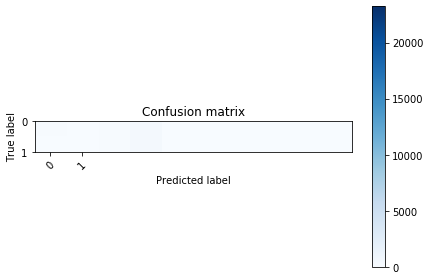

In [78]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, [0, 1])
plt.show()

In [81]:
print(confusion_matrix)
print(classification)
print(accuracy)

<function confusion_matrix at 0x000002268DF1E5E8>
              precision    recall  f1-score   support

           0       0.62      0.15      0.24       667
           1       0.00      0.00      0.00       576
           2       0.35      0.19      0.24      4149
           3       0.62      0.85      0.72     11155
           4       0.83      0.86      0.85      6007
           5       1.00      0.97      0.99     14696
           6       1.00      1.00      1.00     23243
           7       0.88      0.67      0.76      3495
           8       0.65      0.34      0.45       392
           9       0.00      0.00      0.00        39

    accuracy                           0.86     64419
   macro avg       0.59      0.50      0.52     64419
weighted avg       0.85      0.86      0.85     64419

0.8628354988435089
